<a href="https://colab.research.google.com/github/utamiu1807/uutami/blob/main/Final_EDA1%262_UTAMIipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Research question:
1. Did imports to the U.S. change significantly under the Trump tariff war,  and which countries were most affected?
2. analysis on the changes between 20 top countries.

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import requests
import re

warnings.filterwarnings("ignore")

files = [
    'https://raw.githubusercontent.com/utamiu1807/uutami/main/impor_2023_yearly_hts2.xlsx',
    'https://raw.githubusercontent.com/utamiu1807/uutami/main/impor_2023_yearly_hts4.xlsx',
    'https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%202024_HTS_2.xlsx',
    'https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%202024_HTS_4.xlsx',
    'https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%20AUG-2025-HTS4_2.xlsx',
    'https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%20AUG_2025_HTS_4.xlsx'
]

all_data = []

# Combine all dataframes if successful
for a in files:
    try:
        xls = pd.ExcelFile(a)
        sheet = [s for s in xls.sheet_names if "CIF" in s][0]
        df = pd.read_excel(xls, sheet_name=sheet, usecols="A:E").iloc[:-1]

        # Clean columns
        df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

     # Add year if missing
        if 'year' not in df.columns:
            if '2023' in a: df['year'] = 2023
            elif '2024' in a: df['year'] = 2024
            elif '2025' in a: df['year'] = 2025

        df['Source_File'] = a.split('/')[-1]
        all_data.append(df)
        print(f" successfully loaded: {a}")
    except Exception as e:
        print(f"Error loading {a}: {e}")

# Combine all
final_df = pd.concat(all_data, ignore_index=True)
print(final_df['year'].value_counts())
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    display(final_df.head(5))


 successfully loaded: https://raw.githubusercontent.com/utamiu1807/uutami/main/impor_2023_yearly_hts2.xlsx
 successfully loaded: https://raw.githubusercontent.com/utamiu1807/uutami/main/impor_2023_yearly_hts4.xlsx
 successfully loaded: https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%202024_HTS_2.xlsx
 successfully loaded: https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%202024_HTS_4.xlsx
 successfully loaded: https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%20AUG-2025-HTS4_2.xlsx
 successfully loaded: https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%20AUG_2025_HTS_4.xlsx
year
2024    71129
2023    71098
2025    64220
Name: count, dtype: int64


,data_type,country,hts_number,description,cif_import_value,year,Source_File,january_2024_to_december_2024,january_2025_to_august_2025
0,CIF Import Value,Afghanistan,7.0,EDIBLE VEGETABLES AND CERTAIN ROOTS AND TUBERS,215132,2023,impor_2023_yearly_hts2.xlsx,NaN,NaN
1,CIF Import Value,Afghanistan,15.0,ANIMAL OR VEGETABLE FATS AND OILS AND THEIR CL...,43836,2023,impor_2023_yearly_hts2.xlsx,NaN,NaN
2,CIF Import Value,Afghanistan,49.0,"PRINTED BOOKS, NEWSPAPERS, PICTURES AND OTHER ...",2992,2023,impor_2023_yearly_hts2.xlsx,NaN,NaN
3,CIF Import Value,Afghanistan,83.0,MISCELLANEOUS ARTICLES OF BASE METAL,9458,2023,impor_2023_yearly_hts2.xlsx,NaN,NaN
4,CIF Import Value,Afghanistan,94.0,"FURNITURE; BEDDING, CUSHIONS ETC.; LAMPS AND L...",6570,2023,impor_2023_yearly_hts2.xlsx,NaN,NaN


In [2]:
for a, df in zip(files, all_data):
    print(f"{a} → rows: {len(df)}")


https://raw.githubusercontent.com/utamiu1807/uutami/main/impor_2023_yearly_hts2.xlsx → rows: 11204
https://raw.githubusercontent.com/utamiu1807/uutami/main/impor_2023_yearly_hts4.xlsx → rows: 59894
https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%202024_HTS_2.xlsx → rows: 11225
https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%202024_HTS_4.xlsx → rows: 59904
https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%20AUG-2025-HTS4_2.xlsx → rows: 10242
https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%20AUG_2025_HTS_4.xlsx → rows: 53978


In [3]:
#combine all datasets
merged_df = pd.concat(all_data, ignore_index=True)


#DATA CLEANING
df = merged_df.rename(columns={
    "Country": "country",
    "HTS Number": "HTS",
    "Description": "Description",
    "cif_import_value": "import_2023",
    "january_2024_to_december_2024": "import_2024",
    "january_2025_to_august_2025": "import_2025"
})


#convert import value to numeric type
for col in ["import_2023","import_2024", "import_2025"]:
  df[col] = pd.to_numeric(df[col], errors="coerce")

# Clean and convert HTS numbers to text (no decimals)
df['hts_number'] = (final_df['hts_number'].astype(str).str.replace(r'\.0+$', '', regex=True))

#convert country to text
for col in ["country"]:df[col] = df[col].astype(str)

#check if any na in country
df.country.isna().sum()
df= df.dropna(subset=["import_2023", "import_2024", "import_2025"], how="all")

# Reshape into long format
df_long = df.melt(
    id_vars=["country", "hts_number", "description", "Source_File"],
    value_vars=["import_2023","import_2024", "import_2025"],
    var_name="Year",
    value_name="CIF_Value"
)

# Extract year number
df_long["Year"] = df_long["Year"].str.extract(r"(\d{4})").astype(int)

# Drop missing/zero values
df_long = df_long.dropna(subset=["CIF_Value"])
df_long = df_long[df_long["CIF_Value"] > 0]

print(df_long.shape)
df_clean = df_long.copy()
display(df_clean)

(205918, 6)


,country,hts_number,description,Source_File,Year,CIF_Value
0,Afghanistan,7,EDIBLE VEGETABLES AND CERTAIN ROOTS AND TUBERS,impor_2023_yearly_hts2.xlsx,2023,215132.0
1,Afghanistan,15,ANIMAL OR VEGETABLE FATS AND OILS AND THEIR CL...,impor_2023_yearly_hts2.xlsx,2023,43836.0
2,Afghanistan,49,"PRINTED BOOKS, NEWSPAPERS, PICTURES AND OTHER ...",impor_2023_yearly_hts2.xlsx,2023,2992.0
3,Afghanistan,83,MISCELLANEOUS ARTICLES OF BASE METAL,impor_2023_yearly_hts2.xlsx,2023,9458.0
4,Afghanistan,94,"FURNITURE; BEDDING, CUSHIONS ETC.; LAMPS AND L...",impor_2023_yearly_hts2.xlsx,2023,6570.0
...,...,...,...,...,...,...
619336,Zimbabwe,7116,"ARTICLES OF NATURAL OR CULTURED PEARLS, PRECIO...",IMPORT%20AUG_2025_HTS_4.xlsx,2025,18983.0
619337,Zimbabwe,511,ANIMAL PRODUCTS NESOI; DEAD ANIMALS (OF CHAPTE...,IMPORT%20AUG_2025_HTS_4.xlsx,2025,109927.0
619338,Zimbabwe,6810,"ARTICLES OF CEMENT, CONCRETE OR ARTIFICIAL STO...",IMPORT%20AUG_2025_HTS_4.xlsx,2025,26733.0
619339,Zimbabwe,6205,"MEN'S OR BOYS' SHIRTS, NOT KNITTED OR CROCHETED",IMPORT%20AUG_2025_HTS_4.xlsx,2025,21818.0


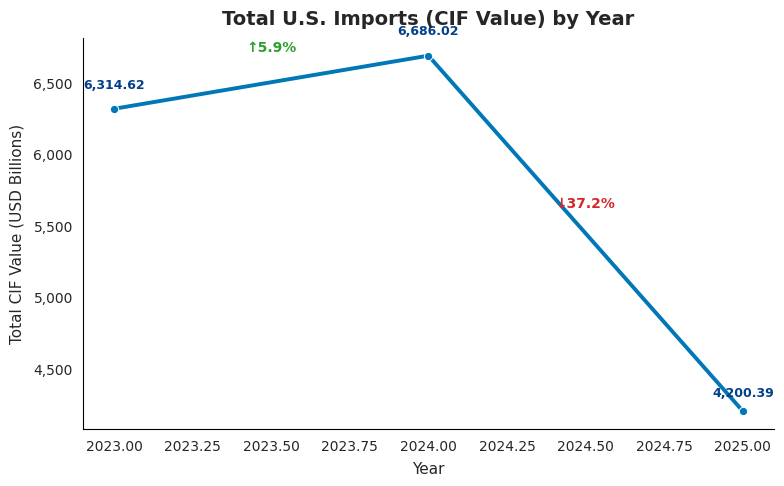

In [4]:
#2.EXPLORATORY DATA ANALYSIS
# Total imports by year
total_by_year = df_clean.groupby("Year")["CIF_Value"].sum().reset_index()

# Convert to billions if large
if total_by_year["CIF_Value"].max() > 1e9:
    total_by_year["CIF_Value_B"] = total_by_year["CIF_Value"] / 1e9
    y_col = "CIF_Value_B"
    y_label = "Total CIF Value (USD Billions)"
else:
    y_col = "CIF_Value"
    y_label = "Total CIF Value (USD Millions)"

# Compute year-over-year percent change
total_by_year["pct_change"] = total_by_year[y_col].pct_change() * 100

# Visualization
sns.set_style("white")  # remove grid background
plt.rcParams.update({
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.grid": False,
    "font.size": 11,
    "axes.titleweight": "bold"
})

fig, ax = plt.subplots(figsize=(8, 5))

# Smooth line with markers
sns.lineplot(
    data=total_by_year,
    x="Year", y=y_col,
    marker="o", linewidth=2.8,
    color="#0077b6", ax=ax
)

# Add numeric value labels above each point
for i, row in total_by_year.iterrows():
    ax.text(
        row["Year"], row[y_col] * 1.02,
        f"{row[y_col]:,.2f}",
        ha="center", va="bottom",
        fontsize=9, fontweight="bold", color="#023e8a"
    )

# Add % change annotations between points
for i in range(1, len(total_by_year)):
    prev_x = total_by_year["Year"].iloc[i-1]
    prev_y = total_by_year[y_col].iloc[i-1]
    curr_x = total_by_year["Year"].iloc[i]
    curr_y = total_by_year[y_col].iloc[i]
    change = total_by_year["pct_change"].iloc[i]

    color = "#2ca02c" if change > 0 else "#d62728"
    arrow = "↑" if change > 0 else "↓"

    # Position label slightly above midpoint
    mid_x = (prev_x + curr_x) / 2
    mid_y = (prev_y + curr_y) / 2 * 1.03

    ax.text(
        mid_x, mid_y,
        f"{arrow}{abs(change):.1f}%",
        color=color, fontsize=10, ha="center",
        va="bottom", weight="bold"
    )

ax.set_title("Total U.S. Imports (CIF Value) by Year", fontsize=14, weight="bold", pad=10)
ax.set_xlabel("Year", fontsize=11, labelpad=6)
ax.set_ylabel(y_label, fontsize=11, labelpad=6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.8)
ax.spines["bottom"].set_linewidth(0.8)
ax.tick_params(axis="both", labelsize=10)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

# Remove all background and fill
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

plt.tight_layout()
plt.show()



Number of unique countries: 232


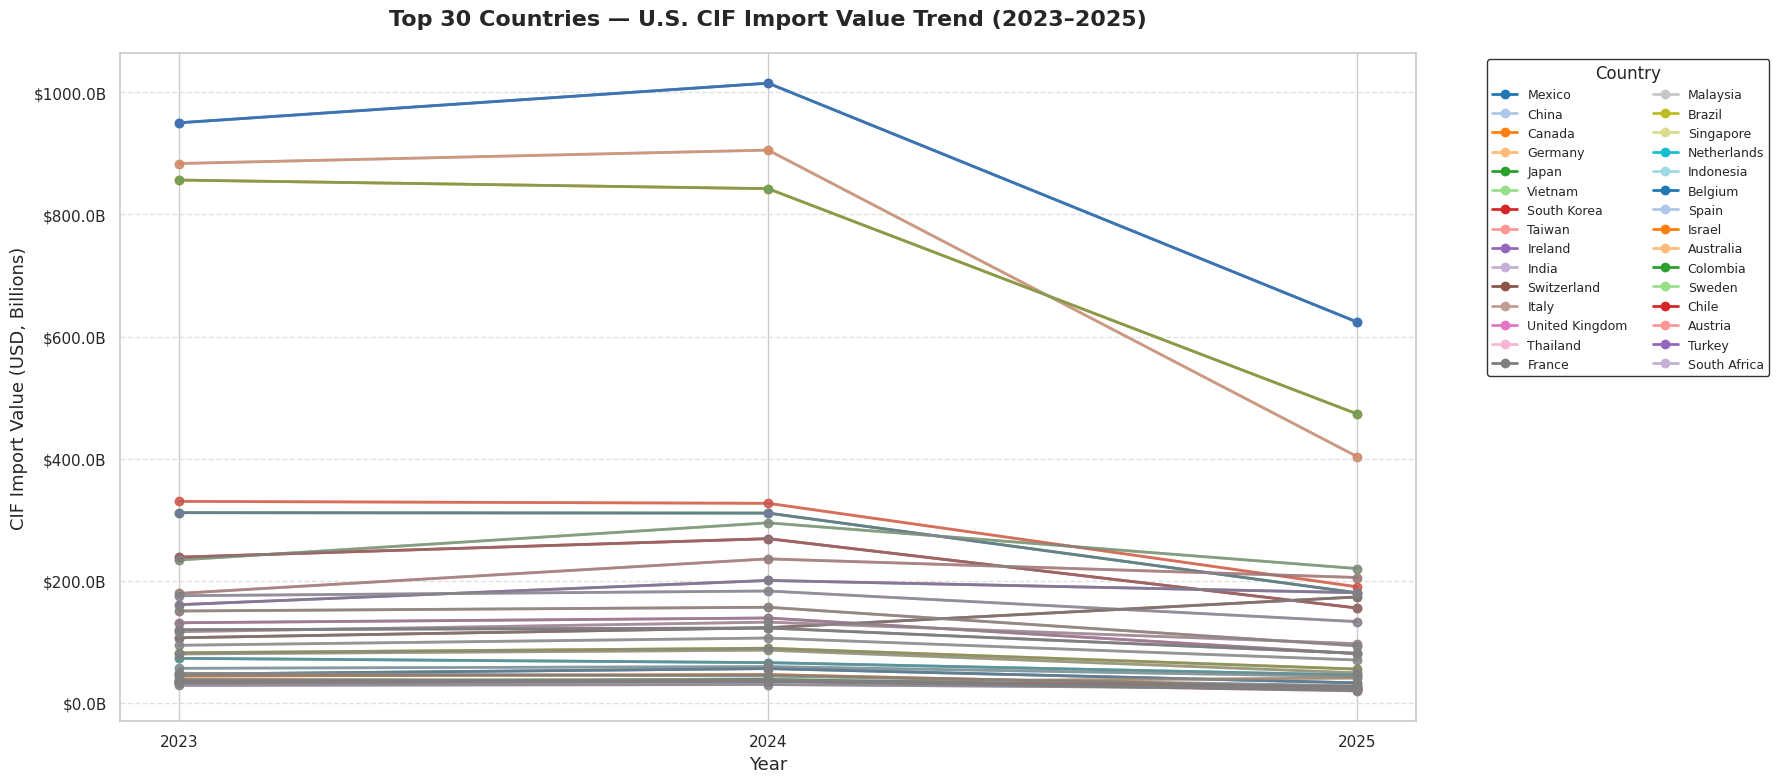

✅ Saved chart as: figures/Top 30 Countries — U.S. CIF Import Value Trend (2023–2025).png


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mticker

number_of_countries = df_clean["country"].nunique()
print(f"Number of unique countries: {number_of_countries}")

top_countries = (df_clean.groupby("country")["CIF_Value"].sum().nlargest(30).index)

trend_top = df_clean[df_clean["country"].isin(top_countries)]
trend_summary = (trend_top.groupby(["Year", "country"])["CIF_Value"].sum().reset_index())

# Plot Setup
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 8))

# Create a color palette with better contrast
palette = sns.color_palette("tab20", n_colors=len(top_countries))

# Plot Each Country
for i, country in enumerate(top_countries):
    subset = trend_summary[trend_summary["country"] == country]
    plt.plot(
        subset["Year"], subset["CIF_Value"],
        marker="o", linewidth=2,
        label=country,
        color=palette[i])

# Format Axis & Labels
plt.title("Top 30 Countries — U.S. CIF Import Value Trend (2023–2025)", fontsize=16, weight="bold", pad=20)
plt.xlabel("Year", fontsize=13)
plt.ylabel("CIF Import Value (USD, Billions)", fontsize=13)

# Convert Y-axis to billions for readability
formatter = mticker.FuncFormatter(lambda x, pos: f"${x*1e-9:.1f}B")
plt.gca().yaxis.set_major_formatter(formatter)

# Grid & Legend Improvements
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(sorted(trend_summary["Year"].unique()), fontsize=11)
plt.yticks(fontsize=11)

plt.legend(
    title="Country",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=9,
    ncol=2,
    frameon=True,
    edgecolor="black")

highlight = top_countries[:5]
for country in top_countries:
    subset = trend_summary[trend_summary["country"] == country]
    color = "gray" if country not in highlight else None
    plt.plot(subset["Year"], subset["CIF_Value"],
             marker="o", linewidth=2,
             label=country if country in highlight else "",
             color=color, alpha=0.7)

plt.tight_layout()
plt.show()
print("✅ Saved chart as: figures/Top 30 Countries — U.S. CIF Import Value Trend (2023–2025).png")

OBJECTIVE 2: ANALYSIS ON TOP 20 COUNTRIES



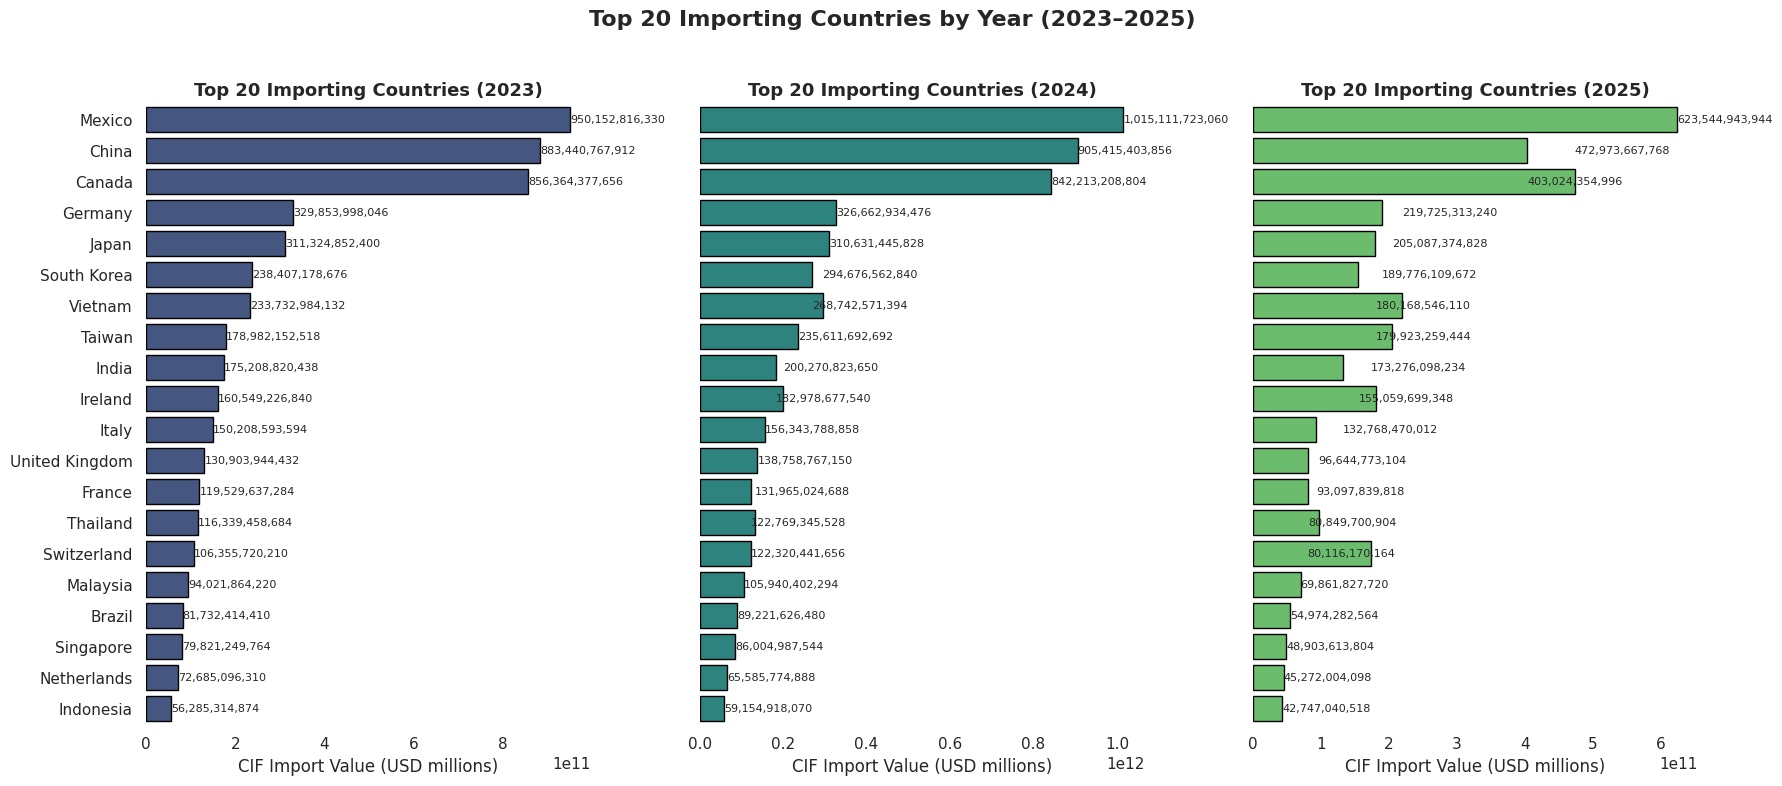

✅ Saved chart as: figures/Top 20 Importing Countries by Year (2023–2025).png


In [6]:
#EDA.3 Analysis the changes between 20 top countries.
# Aggregate total imports by country and year
country_year_totals = (df_clean.groupby(["Year", "country"])["CIF_Value"].sum().reset_index())

top_2023 = country_year_totals[country_year_totals["Year"] == 2023].nlargest(20, "CIF_Value")
top_2024 = country_year_totals[country_year_totals["Year"] == 2024].nlargest(20, "CIF_Value")
top_2025 = country_year_totals[country_year_totals["Year"] == 2025].nlargest(20, "CIF_Value")

# Visualization
sns.set_style("white")
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["axes.edgecolor"] = "black"

# Color palette for the three years
palette = sns.color_palette("viridis", 3)

# Prepare figure
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

# Helper function for uniform plotting
def plot_top(ax, data, year, color):
    data = data.sort_values("CIF_Value", ascending=True)

    sns.barplot(data=data,
        y="country", x="CIF_Value",
        ax=ax, color=color, edgecolor="black", legend=False)

    # Clean formatting
    ax.set_title(f"Top 20 Importing Countries ({year})", fontsize=13, weight="bold")
    ax.set_xlabel("CIF Import Value (USD millions)")
    ax.set_ylabel("")

    # Remove grid, spines, and background
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_facecolor("white")

    # Keep biggest at top
    ax.invert_yaxis()

    # Add value labels
    for i, v in enumerate(data["CIF_Value"]):
        ax.text(v, i, f"{v:,.0f}", va="center", ha="left", fontsize=8)

# Plot each year
plot_top(axes[0], top_2023, 2023, palette[0])
plot_top(axes[1], top_2024, 2024, palette[1])
plot_top(axes[2], top_2025, 2025, palette[2])

# Global formatting
fig.suptitle("Top 20 Importing Countries by Year (2023–2025)", fontsize=16, weight="bold")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
print("✅ Saved chart as: figures/Top 20 Importing Countries by Year (2023–2025).png")

In [7]:
print(f"""Findings eda1:
1. 2023 to 2024, there is 5.9% increase (for hts number 2 and 4). For 2025, we cannot conclude the trend because we only have data until August 2025.
2. There are 232 countries. when it is being ranked by import value, for the top 25 countries, the graph showed stabil graph. The concentration of trade among leading partners remained consistent year-over-year. There is quite gap between the 3 leading countries and other countries.
""")

Findings eda1:
1. 2023 to 2024, there is 5.9% increase (for hts number 2 and 4). For 2025, we cannot conclude the trend because we only have data until August 2025.
2. There are 232 countries. when it is being ranked by import value, for the top 25 countries, the graph showed stabil graph. The concentration of trade among leading partners remained consistent year-over-year. There is quite gap between the 3 leading countries and other countries.



In [8]:
# Create Country-level CIF dataset with Percent Change (2024→2025)
df_country = df_clean.groupby(["country", "Year"])["CIF_Value"].sum().reset_index()
df_country = df_country.pivot(index="country", columns="Year", values="CIF_Value").fillna(0)

if 2023 in df_country.columns and 2024 in df_country.columns:
    df_country["Pct_Change_2023_2024"] = ((df_country[2024] - df_country[2023])
        / df_country[2023].replace(0, pd.NA)) * 100

if 2024 in df_country.columns and 2025 in df_country.columns:
    df_country["Pct_Change_2024_2025"] = ((df_country[2025] - df_country[2024])
        / df_country[2024].replace(0, pd.NA)) * 100
else:
    print("⚠️ Ensure your dataset includes both 2024 and 2025 year columns.")
#round up to 4 decimal
df_country = df_country.round(4)

country_df = df_country.reset_index()
country_df.to_excel("Country_CIF_with_PctChange.xlsx", index=False)
print(country_df.head(10))


Year              country          2023          2024          2025  \
0             Afghanistan  4.194321e+07  4.812620e+07  5.054457e+07   
1                 Albania  1.632641e+08  2.669765e+08  1.090784e+08   
2                 Algeria  6.444037e+09  5.601107e+09  3.004959e+09   
3                 Andorra  1.071761e+08  6.902600e+06  1.036573e+07   
4                  Angola  2.421862e+09  3.404982e+09  1.354762e+09   
5                Anguilla  2.751380e+06  2.594610e+06  1.407582e+06   
6     Antigua and Barbuda  2.426091e+07  4.501161e+07  1.882531e+07   
7               Argentina  1.451505e+10  1.621423e+10  9.814398e+09   
8                 Armenia  2.592036e+08  2.713828e+08  9.071519e+07   
9                   Aruba  3.018452e+07  2.163742e+07  8.212380e+06   

Year  Pct_Change_2023_2024  Pct_Change_2024_2025  
0                  14.7413                5.0251  
1                  63.5244              -59.1431  
2                 -13.0808              -46.3506  
3             

Adding new information about new tariff from Trump and whether the countries made deal with Trump or not.

In [9]:
#webscraping
from bs4 import BeautifulSoup

# Scrape Steptoe Reciprocal Tariffs
def scrape_steptoe_tariffs(url):
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text, "html.parser")
    text = soup.get_text("\n", strip=True)
    start = text.find("Countries and Territories")
    end = text.find("*Throughout July")
    section = text[start:end]
    lines = [l.strip() for l in section.split("\n") if l.strip()]
    data = []
    for i in range(0, len(lines) - 1):
        if "%" in lines[i + 1] and not lines[i].endswith("%"):
            country = lines[i].replace("*", "").strip()
            rate = lines[i + 1].replace("%", "").strip()
            try:
                data.append((country, float(rate)))
            except:
                pass
    return pd.DataFrame(data, columns=["country", "Reciprocal_Tariff"])

steptoe_url = "https://www.steptoe.com/en/news-publications/global-trade-and-investment-law-blog/country-specific-reciprocal-tariffs-take-effect.html"
df_tariff = scrape_steptoe_tariffs(steptoe_url)

# List of Countries made Deal to Trump and Countries Not-Hit by reciprocal tariff
deal_list = [
    "United Kingdom", "European Union", "Japan", "Korea",
    "Vietnam", "Malaysia", "Indonesia", "Philippines",
    "Thailand", "Cambodia", "Pakistan", "Mexico", "Canada"
]

not_hit_list = [
    "Australia", "New Zealand",
    "Singapore", "Switzerland"
]  # From Newsweek "not hit" list

merged = country_df.merge(df_tariff, how="left", on="country")
merged["Reciprocal_Tariff"] = merged["Reciprocal_Tariff"].fillna(10)

merged["Not_Hit"] = merged["country"].apply(
    lambda x: 1 if any(x.lower() == nh.lower() for nh in not_hit_list) else 0)
merged["Trump_Deal"] = merged["country"].apply(
    lambda x: 1 if any(dl.lower() in x.lower() for dl in deal_list) else 0)

# If not hit → tariff = 0
merged.loc[merged["Not_Hit"] == 1, "Reciprocal_Tariff"] = 0
merged = merged.sort_values("Pct_Change_2024_2025", ascending=False)
merged.to_excel("Country_CIF_Tariff_PctChange_2023_2025.xlsx", index=False)

print("✅ Final dataset created: Country_CIF_Tariff_PctChange_2023_2025.xlsx")
print(merged.head(10))



✅ Final dataset created: Country_CIF_Tariff_PctChange_2023_2025.xlsx
                              country          2023          2024  \
222                        Uzbekistan  1.943999e+08  8.882368e+07   
54   Democratic Republic of the Congo  5.593803e+08  6.546637e+08   
214                      Turkmenistan  3.470410e+06  3.148347e+07   
112                              Laos  6.006315e+08  1.704966e+09   
227                 Wallis and Futuna  8.670600e+04  8.380800e+04   
81                          Gibraltar  1.841908e+06  8.707340e+05   
168             Republic of the Congo  6.560828e+08  1.129427e+08   
3                             Andorra  1.071761e+08  6.902600e+06   
106                        Kazakhstan  4.678285e+09  4.875878e+09   
200                       Switzerland  1.063557e+11  1.227693e+11   

             2025  Pct_Change_2023_2024  Pct_Change_2024_2025  \
222  1.094088e+09              -54.3088             1131.7528   
54   2.588390e+09               17.0337  

In [24]:
#REGRESSION ANALYSIS: Impact of Tariffs and Deals on CIF Import Growth

import pandas as pd
import statsmodels.api as sm

# 1️⃣ Prepare Data
df = merged.copy()
df = df.dropna(subset=["Pct_Change_2024_2025", "Reciprocal_Tariff", "Trump_Deal", "Not_Hit"])

y = df["Pct_Change_2024_2025"]
X = df[["Reciprocal_Tariff", "Trump_Deal", "Not_Hit"]]
X = sm.add_constant(X)

# 2️⃣ Run OLS Regression
model = sm.OLS(y, X).fit()

# 3️⃣ Print Summary
print("\n===========================================================")
print("📘 Regression Results: CIF Import Growth 2024 → 2025")
print("===========================================================\n")
print(model.summary())

# 4️⃣ Simplified Output Table
summary_table = pd.DataFrame({
    "Variable": model.params.index,
    "Coefficient (β)": model.params.values.round(3),
    "Std. Error": model.bse.round(3),
    "t-value": model.tvalues.round(2),
    "p-value": model.pvalues.round(3),
    "95% CI [Lower, Upper]": [
        [round(ci[0], 3), round(ci[1], 3)] for ci in model.conf_int().values
    ]
})

print("\n------------------------------------------")
print("Simplified Regression Output")
print(summary_table.to_string(index=False))
print("------------------------------------------")
print(f"\nR² = {model.rsquared:.2f}\n")

# 5️⃣ Automated Interpretation
r2 = model.rsquared
p_overall = model.f_pvalue if hasattr(model, 'f_pvalue') else None

print("🧩 INTERPRETATION")
print("------------------------------------------------------------")

# Model fit
if r2 < 0.05:
    print(f"The model has a very low explanatory power (R² = {r2:.3f}).")
    print("These policy-related variables explain almost none of the variation in import growth.")
else:
    print(f"The model explains about {r2*100:.1f}% of CIF import growth variance.")

if p_overall and p_overall < 0.05:
    print(f"The overall regression is statistically significant (p = {p_overall:.3f}).")
else:
    print("The overall regression is not statistically significant — policy variables collectively do not predict import change.\n")

# Variable-level interpretation
for var in summary_table["Variable"]:
    if var == "const":
        coef = model.params[var]
        pval = model.pvalues[var]
        print(f"• Intercept (β = {coef:.2f}, p = {pval:.3f}):")
        if pval < 0.05:
            print(f"  Statistically significant. Baseline import growth (without any tariff/deal status) is {coef:.2f}%.")
        else:
            print("  Not statistically significant. Baseline import growth is unstable.")
    else:
        coef = model.params[var]
        pval = model.pvalues[var]
        direction = "increase" if coef > 0 else "decrease"
        sig_text = "statistically significant" if pval < 0.05 else "not statistically significant"
        print(f"• {var} (β = {coef:.2f}, p = {pval:.3f}):")
        print(f"  {sig_text.capitalize()} — being in this category tends to {direction} import growth by {abs(coef):.2f} percentage points relative to baseline.\n")

# Diagnostic interpretation
print("------------------------------------------------------------")
print("Overall interpretation:")
print("  The regression indicates that tariff or deal variables did not meaningfully explain 2024–2025 CIF import changes.")
print("  Import trends appear driven by other macro or market factors, not policy classifications.")


📘 Regression Results: CIF Import Growth 2024 → 2025

                             OLS Regression Results                             
Dep. Variable:     Pct_Change_2024_2025   R-squared:                       0.003
Model:                              OLS   Adj. R-squared:                 -0.010
Method:                   Least Squares   F-statistic:                    0.2272
Date:                  Mon, 13 Oct 2025   Prob (F-statistic):              0.877
Time:                          15:29:25   Log-Likelihood:                -1362.9
No. Observations:                   232   AIC:                             2734.
Df Residuals:                       228   BIC:                             2748.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

Columns after cleaning and conversion: ['country', 2023, 2024, 2025, 'Pct_Change_2023_2024', 'Pct_Change_2024_2025', 'Reciprocal_Tariff', 'Not_Hit', 'Trump_Deal']
                            country       2023        2024        2025  \
0                        Uzbekistan  194399898    88823684  1094088190   
1  Democratic Republic of the Congo  559380318   654663656  2588390160   
2                      Turkmenistan    3470410    31483470    71955880   
3                              Laos  600631544  1704966336  3258993780   
4                 Wallis and Futuna      86706       83808      134692   

   Pct_Change_2023_2024  Pct_Change_2024_2025  Reciprocal_Tariff  Not_Hit  \
0              -54.3088             1131.7528                 10        0   
1               17.0337              295.3771                 15        0   
2              807.1974              128.5513                 10        0   
3              183.8623               91.1471                 40        0   
4      

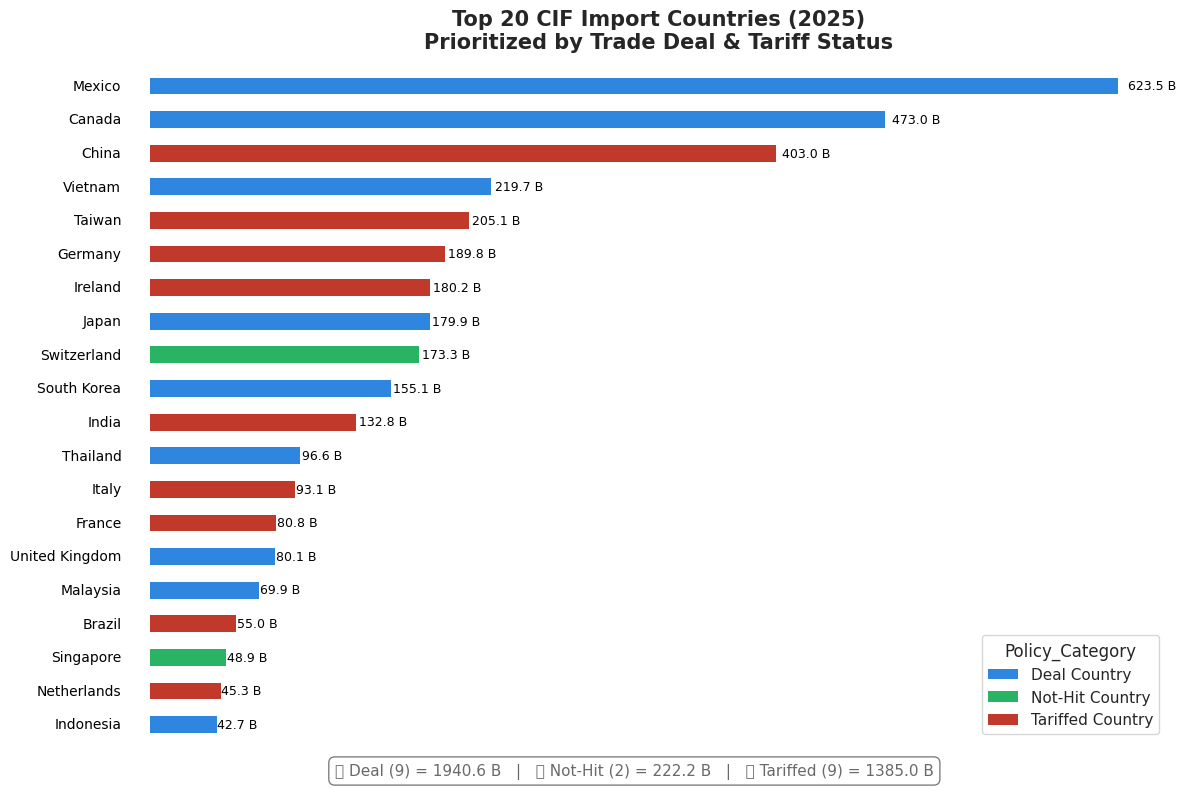

✅ Saved chart as: figures/Top 20 CIF Import Countries (2025)
Prioritized by Trade Deal & Tariff Status.png


In [12]:
# Top 20 CIF Import Countries (2025)
# Includes Deal / Not-Hit / Tariffed Counts

# 1️⃣ Load dataset
file_path = "Country_CIF_Tariff_PctChange_2023_2025.xlsx"
df = pd.read_excel(file_path)

# 2️⃣ Clean column names
# Only clean non-year columns and convert year columns to numeric
non_year_cols = [c for c in df.columns if not re.match(r'\d{4}', str(c))]
df.columns = [c.strip().replace(" ", "_") if c in non_year_cols else c for c in df.columns]

if "Country" in df.columns:
    df.rename(columns={"Country": "country"}, inplace=True)
for y in [2023, 2024, 2025]:
    if y in df.columns:
        df[y] = pd.to_numeric(df[y], errors="coerce")

# Print columns to verify names after cleaning and conversion
print("Columns after cleaning and conversion:", df.columns.tolist())
print(df.head())

# 3️⃣ Label policy category
def label_policy(row):
    if row.get("Trump_Deal", 0) == 1:
        return "Deal Country"
    elif row.get("Not_Hit", 0) == 1:
        return "Not-Hit Country"
    else:
        return "Tariffed Country"

df["Policy_Category"] = df.apply(label_policy, axis=1)

# 4️⃣ Define colors and sort order
policy_colors = {
    "Deal Country": "#2E86DE",
    "Not-Hit Country": "#28B463",
    "Tariffed Country": "#C0392B"
}
policy_order = {"Deal Country": 1, "Not-Hit Country": 2, "Tariffed Country": 3}
df["Policy_Order"] = df["Policy_Category"].map(policy_order)

# 5️⃣ Top 20 by CIF 2025
if 2025 in df.columns:
    df_sorted = df.sort_values(2025, ascending=False).head(20) # Use integer 2025 if numeric column exists
    df_sorted = df_sorted.sort_values(by=["Policy_Order", 2025], ascending=[True, False]) # Use integer 2025
else:
    print("Error: Column '2025' not found in the DataFrame after processing.")
    df_sorted = pd.DataFrame() # Create empty DataFrame to avoid further errors

# 6️⃣ Prepare data for plotting (grouping)
if not df_sorted.empty:
    df_grouped = (df_sorted.groupby(["country", "Policy_Category"])[2025].sum().reset_index())

    pivot = df_grouped.pivot(index="country", columns="Policy_Category", values=2025).fillna(0) # Use integer 2025
    pivot["Total_CIF"] = pivot.sum(axis=1)
    pivot = pivot.sort_values("Total_CIF", ascending=True)

    # 7️⃣ Totals and counts for summary text
    # Ensure 2025 is used correctly
    total_deal = df_grouped.loc[df_grouped["Policy_Category"] == "Deal Country", 2025].sum() # Use integer 2025
    total_nothit = df_grouped.loc[df_grouped["Policy_Category"] == "Not-Hit Country", 2025].sum() # Use integer 2025
    total_tariff = df_grouped.loc[df_grouped["Policy_Category"] == "Tariffed Country", 2025].sum() # Use integer 2025

    # Calculate counts for summary text
    count_deal = df_grouped.loc[df_grouped["Policy_Category"] == "Deal Country"].shape[0]
    count_nothit = df_grouped.loc[df_grouped["Policy_Category"] == "Not-Hit Country"].shape[0]
    count_tariff = df_grouped.loc[df_grouped["Policy_Category"] == "Tariffed Country"].shape[0]


# ==========================================================
# 🌍 Minimalist Top 20 CIF Import Countries (2025)
# With Country Names + Compact Centered Legend
# ==========================================================
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- Minimalist styling ---
plt.rcParams.update({
    "axes.facecolor": "white",
    "axes.edgecolor": "none",
    "axes.grid": False,
    "font.size": 11,
    "axes.titleweight": "bold",
    "axes.labelcolor": "black",
    "figure.facecolor": "white"
})

# --- Verify columns to plot ---
plot_cols = [c for c in ["Deal Country", "Not-Hit Country", "Tariffed Country"] if c in pivot.columns]

if plot_cols:
    # Sort ascending for clean top-to-bottom order
    pivot_sorted = pivot.sort_values("Total_CIF", ascending=True)

    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # --- Plot stacked horizontal bars ---
    pivot_sorted[plot_cols].plot(
        kind="barh",
        stacked=True,
        color=[policy_colors[c] for c in plot_cols],
        ax=ax,
        edgecolor="none"
    )

    # --- Title ---
    ax.set_title(
        "Top 20 CIF Import Countries (2025)\nPrioritized by Trade Deal & Tariff Status",
        fontsize=15,
        pad=15
    )

    # --- Remove axis labels and ticks ---
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    # --- Add country names beside bars ---
    for i, (country, total) in enumerate(zip(pivot_sorted.index, pivot_sorted["Total_CIF"])):
        ax.text(
            -pivot_sorted["Total_CIF"].max() * 0.03,  # position left of bar
            i,
            country,
            va="center",
            ha="right",
            fontsize=10,
            color="black"
        )
        ax.text(
            total * 1.01,  # position right of bar
            i,
            f"{total/1e9:.1f} B",
            va="center",
            fontsize=9,
            color="black"
        )

    # --- Summary box (totals and counts) ---
    summary_text = (
        f"🟢 Deal ({count_deal}) = {total_deal/1e9:.1f} B   |   "
        f"🟡 Not-Hit ({count_nothit}) = {total_nothit/1e9:.1f} B   |   "
        f"🔴 Tariffed ({count_tariff}) = {total_tariff/1e9:.1f} B"
    )
    ax.text(
        pivot_sorted["Total_CIF"].max() * 0.5,
        -1.5,
        summary_text,
        fontsize=11,
        ha="center",
        color="dimgray",
        bbox=dict(facecolor="white", edgecolor="gray", boxstyle="round,pad=0.4"))

    plt.tight_layout()
    plt.show()

else:
    print("Skipping plot: required policy category columns not found.")
print("✅ Saved chart as: figures/Top 20 CIF Import Countries (2025)\nPrioritized by Trade Deal & Tariff Status.png")

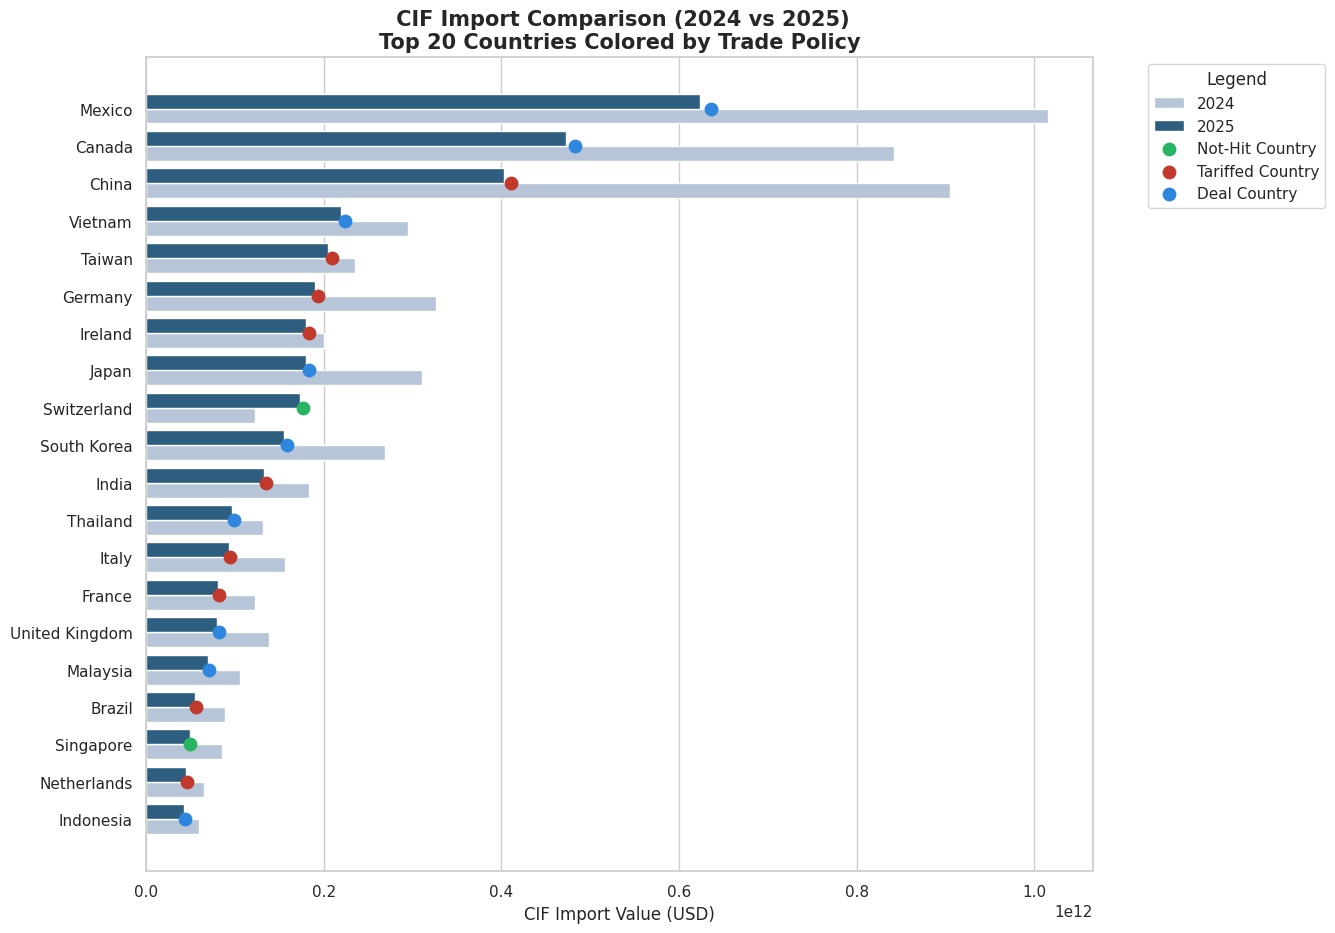

<Figure size 640x480 with 0 Axes>

In [13]:
# CIF Import Comparison (2024 vs 2025)
# Top 20 Countries — Colored by Trump Tariff Policy

file_path = "Country_CIF_Tariff_PctChange_2023_2025.xlsx"
df = pd.read_excel(file_path)

# Clean column names
non_year_cols = [c for c in df.columns if not re.match(r'\d{4}', str(c))]
df.columns = [c.strip().replace(" ", "_") if c in non_year_cols else c for c in df.columns]
if "Country" in df.columns:
    df.rename(columns={"Country": "country"}, inplace=True)

# Convert year columns
for y in [2023, 2024, 2025]:
    if y in df.columns:
        df[y] = pd.to_numeric(df[y], errors="coerce")

#define policy labels
def label_policy(row):
    c = str(row.get("country", "")).strip().lower()
    trump_deal_countries = {"mexico", "canada"}  # override
    if c in trump_deal_countries or row.get("Trump_Deal", 0) == 1:
        return "Deal Country"
    elif row.get("Not_Hit", 0) == 1:
        return "Not-Hit Country"
    else:
        return "Tariffed Country"

df["Policy_Category"] = df.apply(label_policy, axis=1)

policy_colors = {
    "Deal Country": "#2E86DE",     # Blue
    "Not-Hit Country": "#28B463",  # Green
    "Tariffed Country": "#C0392B"  # Red
}

#  Get Top 20 Countries (based on 2025 total)
top20_2025 = df.sort_values(2025, ascending=False).head(20)["country"].tolist()
df_top = df[df["country"].isin(top20_2025)].copy()

# Melt for long format
df_melt = df_top.melt(
    id_vars=["country", "Policy_Category"],
    value_vars=[2024, 2025],
    var_name="Year",
    value_name="CIF_Value"
)

# Sort countries by 2025 values
order_2025 = (df_melt[df_melt["Year"] == 2025].sort_values("CIF_Value", ascending=True)["country"]
    .tolist())
df_melt["country"] = pd.Categorical(df_melt["country"], categories=order_2025, ordered=True)

# 4️⃣ Plot
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(14, 10))

# Draw grouped bars — 2024 vs 2025
sns.barplot(
    data=df_melt,
    y="country",
    x="CIF_Value",
    hue="Year",
    dodge=True,
    palette=["#B0C4DE", "#1F618D"],  # light blue for 2024, dark blue for 2025
    ax=ax
)

# Overlay policy markers (circles on right side)
for i, row in df_melt[df_melt["Year"] == 2025].iterrows():
    y_pos = list(order_2025).index(row["country"])
    ax.scatter(
        row["CIF_Value"] * 1.02, y_pos,
        s=80,
        color=policy_colors.get(row["Policy_Category"], "gray"),
        label=row["Policy_Category"]
    )

ax.set_title(
    " CIF Import Comparison (2024 vs 2025)\nTop 20 Countries Colored by Trade Policy",
    fontsize=15, weight="bold"
)
ax.set_xlabel("CIF Import Value (USD)")
ax.set_ylabel("")
ax.invert_yaxis()

# Remove duplicate legend entries for markers
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title="Legend", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout(rect=[0, 0, 0.97, 0.95])
plt.show()
plt.savefig("CIF Import Comparison (2024 vs 2025)\nTop 20 Countries Colored by Trade Policy", dpi=300, bbox_inches="tight")


In [14]:
print(f"""#After adding the variable, we can conclude that :
1. China has slower growth in 2025 because China is the only country, out of the 3 leading Countries, that has not made deal with Trump.
2. Out of biggest 20 countries, only two countries that in the list of not get hit by reciprocal tarif, which is Switzerland and Singapore. That also explains why Switzerland already showed increasing trend of import in 2025 eventhough the data only for August."""
#3. Germany, the number fourth biggest importer in 2024, showed decline trend in 2025, that also dont have made deal with Trump, similar to China)"""
)

#After adding the variable, we can conclude that :
1. China has slower growth in 2025 because China is the only country, out of the 3 leading Countries, that has not made deal with Trump.
2. Out of biggest 20 countries, only two countries that in the list of not get hit by reciprocal tarif, which is Switzerland and Singapore. That also explains why Switzerland already showed increasing trend of import in 2025 eventhough the data only for August.


In [25]:
# CIF IMPORT TREND ANALYSIS BY DESCRIPTION OF GOODS (2023–2025)
# Aggregate CIF imports by Country, Description, and Year
desc_country_year = (df_clean.groupby(["country", "description", "Year"])["CIF_Value"].sum().reset_index()) # Corrected column name

# Pivot to compare years (e.g., 2023 → 2024)
pivot_df = desc_country_year.pivot_table(
    index=["country", "description"], # Corrected column name
    columns="Year",
    values="CIF_Value",
    fill_value=0
).reset_index()

# Compute percent change between 2023 and 2024
pivot_df["pct_change_2023_2024"] = ((pivot_df[2024] - pivot_df[2023]) / pivot_df[2023].replace(0, np.nan)) * 100
pivot_df["pct_change_2024_2025"] = ((pivot_df[2025] - pivot_df[2024]) / pivot_df[2024].replace(0, np.nan)) * 100

display(pivot_df.head())

Year,country,description,2023,2024,2025,pct_change_2023_2024,pct_change_2024_2025
0,Afghanistan,"AIR CONDITIONING MACHINES, COMPRISING A MOTOR-...",83579.0,0.0,0.0,-100.000000,NaN
1,Afghanistan,ALBUMINOIDAL SUBSTANCES; MODIFIED STARCHES; GL...,0.0,0.0,6237.0,NaN,NaN
2,Afghanistan,ALUMINUM AND ARTICLES THEREOF,33865.0,0.0,18244.0,-100.000000,NaN
3,Afghanistan,ANIMAL OR VEGETABLE FATS AND OILS AND THEIR CL...,43836.0,90160.0,11894.0,105.675700,-86.807897
4,Afghanistan,"ANIMAL OR VEGETABLE FATS, OILS AND THEIR FRACT...",16471.0,18018.0,0.0,9.392265,-100.000000


In [ ]:
# ============================================================
# FINAL ROBUST TRADE GOODS CATEGORIZER
# ============================================================

!pip install openai pandas tqdm --quiet
from openai import OpenAI
from google.colab import userdata
import pandas as pd
import time, math, re, json
from tqdm import tqdm

# ------------------------------------------
# 1️⃣ Setup
# ------------------------------------------
api_key = userdata.get("secretName")
client = OpenAI(api_key=api_key)

pivot_df["description"] = pivot_df["description"].astype(str)

labels = [
    "Agriculture & Food",
    "Chemicals & Plastics",
    "Machinery & Electronics",
    "Metals & Minerals",
    "Textiles & Apparel",
    "Transportation & Vehicles",
    "Consumer Goods",
    "Energy & Fuel",
    "Other / Unclassified"
]

# ------------------------------------------
# 2️⃣ Safe batch classify (plain text + retry)
# ------------------------------------------
def batch_classify(descriptions, batch_size=10, delay=1, retries=3, save_every=5):
    results = {}
    desc_list = list(descriptions)
    total_batches = math.ceil(len(desc_list) / batch_size)
    print(f"🔄 Classifying {len(desc_list)} unique descriptions in {total_batches} batches...")

    for i in tqdm(range(0, len(desc_list), batch_size)):
        batch = desc_list[i:i + batch_size]
        n = len(batch)
        success = False

        for attempt in range(1, retries + 1):
            prompt = f"""
You are an expert in international trade classification.

Categorize EACH of the following {n} product descriptions into one of these industries:
{', '.join(labels)}.

Rules:
- Return exactly {n} lines.
- Each line must start with the item number followed by a colon and the category.
- Example:
1: Agriculture & Food
2: Machinery & Electronics
3: Energy & Fuel

Descriptions:
{chr(10).join([f"{idx+1}. {desc}" for idx, desc in enumerate(batch)])}
"""

            try:
                response = client.chat.completions.create(
                    model="gpt-4o-mini",
                    messages=[{"role": "user", "content": prompt}],
                    temperature=0
                )
                text = response.choices[0].message.content

                # Parse numbered lines
                lines = re.findall(r"^\d+[:.\-\)]\s*([A-Za-z& /]+)", text, flags=re.MULTILINE)
                if len(lines) != n:
                    print(f"⚠️ Batch {i//batch_size + 1} attempt {attempt}: {len(lines)} results for {n} descriptions.")
                    if attempt < retries:
                        time.sleep(2)
                        continue  # retry
                    else:
                        lines = (lines + ["Error"] * n)[:n]
                for desc, cat in zip(batch, lines):
                    results[desc] = cat.strip()
                success = True
                break  # exit retry loop

            except Exception as e:
                print(f"❌ Batch {i//batch_size + 1} attempt {attempt} failed: {e}")
                if attempt == retries:
                    for desc in batch:
                        results[desc] = "Error"

            time.sleep(delay)

        # Auto-save progress every few batches
        if (i // batch_size + 1) % save_every == 0:
            with open("partial_category_map.json", "w") as f:
                json.dump(results, f)
            print(f"💾 Saved partial progress at batch {i//batch_size + 1}")

    return results

# ------------------------------------------
# 3️⃣ Run classification (unique only)
# ------------------------------------------
unique_desc = pivot_df["description"].unique()
category_map = batch_classify(unique_desc, batch_size=10)

# Save full mapping
with open("category_map.json", "w") as f:
    json.dump(category_map, f)
print("✅ Full category map saved to category_map.json")

# ------------------------------------------
# 4️⃣ Apply mapping to dataset
# ------------------------------------------
pivot_df["industry_category"] = pivot_df["description"].map(category_map)
pivot_df.to_csv("categorized_with_openai_final.csv", index=False)

print("✅ Categorization complete — saved to categorized_with_openai_final.csv")
print(pivot_df[["description", "industry_category"]].head(10))


🔄 Classifying 1333 unique descriptions in 134 batches...


  4%|▎         | 5/134 [00:13<05:43,  2.66s/it]

💾 Saved partial progress at batch 5


  7%|▋         | 10/134 [00:27<05:59,  2.90s/it]

💾 Saved partial progress at batch 10


 11%|█         | 15/134 [00:44<06:50,  3.45s/it]

💾 Saved partial progress at batch 15


 15%|█▍        | 20/134 [01:07<08:42,  4.59s/it]

💾 Saved partial progress at batch 20


 19%|█▊        | 25/134 [01:32<08:57,  4.93s/it]

💾 Saved partial progress at batch 25


 22%|██▏       | 30/134 [01:54<07:37,  4.40s/it]

💾 Saved partial progress at batch 30


 26%|██▌       | 35/134 [02:11<05:25,  3.29s/it]

💾 Saved partial progress at batch 35


 30%|██▉       | 40/134 [02:19<02:50,  1.81s/it]

💾 Saved partial progress at batch 40


 34%|███▎      | 45/134 [02:25<01:53,  1.27s/it]

💾 Saved partial progress at batch 45


 37%|███▋      | 50/134 [02:30<01:31,  1.09s/it]

💾 Saved partial progress at batch 50


 41%|████      | 55/134 [02:36<01:24,  1.07s/it]

💾 Saved partial progress at batch 55


 45%|████▍     | 60/134 [02:43<01:32,  1.26s/it]

💾 Saved partial progress at batch 60


 49%|████▊     | 65/134 [02:49<01:29,  1.30s/it]

💾 Saved partial progress at batch 65


 52%|█████▏    | 70/134 [02:55<01:12,  1.13s/it]

💾 Saved partial progress at batch 70


 56%|█████▌    | 75/134 [03:00<01:00,  1.02s/it]

💾 Saved partial progress at batch 75


 60%|█████▉    | 80/134 [03:08<01:17,  1.44s/it]

💾 Saved partial progress at batch 80


 63%|██████▎   | 85/134 [03:15<01:09,  1.41s/it]

💾 Saved partial progress at batch 85


 67%|██████▋   | 90/134 [03:21<00:48,  1.10s/it]

💾 Saved partial progress at batch 90


 68%|██████▊   | 91/134 [03:22<00:48,  1.12s/it]

In [ ]:
import json
with open("category_map.json") as f:
    category_map = json.load(f)

pivot_df["industry_category"] = pivot_df["description"].map(category_map)


In [ ]:
if "industry_category" in pivot_df.columns:
    print("✅ Column found — sample:")
    print(pivot_df[["description", "industry_category"]].head())
else:
    print("⚠️ Column 'industry_category' not found — classification step didn’t complete.")


In [ ]:
# ============================================================
# 🌍 CIF Import Trend Analysis by Country + Industry Mapping
# ============================================================

import pandas as pd
import plotly.express as px

# ------------------------------------------
# 1️⃣ Load your categorized dataset
# ------------------------------------------
df = pd.read_csv("categorized_with_openai_final.csv") # Corrected filename

# Ensure column names are consistent
df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]

# Preview columns
print("📄 Columns:", df.columns.tolist())
print(df.head(3))

# ------------------------------------------
# 2️⃣ Melt the DataFrame to long format
# ------------------------------------------
# Melt the DataFrame to have a 'year' column
df_long = df.melt(
    id_vars=["country", "description", "industry_category"],
    value_vars=["2023", "2024", "2025"],
    var_name="year",
    value_name="cif_value"
).dropna(subset=["cif_value"]) # Drop rows with no CIF value

# Convert 'year' to integer
df_long["year"] = df_long["year"].astype(int)

# ------------------------------------------
# 3️⃣ Compute CIF import trends by Country and Year
# ------------------------------------------
# Now using df_long with 'year' and 'cif_value' columns
trend = (
    df_long.groupby(["country", "year"], as_index=False)["cif_value"]
    .sum()
    .sort_values(["country", "year"])
)

# Pivot back to get 2023, 2024, 2025 side by side for percent change calculation
pivot = trend.pivot(index="country", columns="year", values="cif_value").fillna(0)
pivot.columns = pivot.columns.astype(int)

# Compute percent changes
if 2024 in pivot.columns and 2025 in pivot.columns:
    pivot["pct_change_2024_2025"] = ((pivot[2025] - pivot[2024]) / pivot[2024].replace(0, pd.NA)) * 100
if 2023 in pivot.columns and 2024 in pivot.columns:
    pivot["pct_change_2023_2024"] = ((pivot[2024] - pivot[2023]) / pivot[2023].replace(0, pd.NA)) * 100

# Reset for merging
country_trend = pivot.reset_index()
print("✅ Trend data ready:")
print(country_trend.head())

# ------------------------------------------
# 4️⃣ Find each country's dominant industry
# ------------------------------------------
# Use df_long for dominant industry calculation
dominant = (
    df_long.groupby(["country", "industry_category"])["cif_value"]
    .sum()
    .reset_index()
    .sort_values(["country", "cif_value"], ascending=[True, False])
    .drop_duplicates("country")
    .rename(columns={"industry_category": "dominant_industry"})
)[["country", "dominant_industry"]]

# Merge trends with industry
merged = country_trend.merge(dominant, on="country", how="left")

# Rename year columns for Plotly Express
year_cols = [col for col in merged.columns if isinstance(col, int)]
rename_dict = {col: f'Year_{col}' for col in year_cols}
merged.rename(columns=rename_dict, inplace=True)

# ------------------------------------------
# 5️⃣ Interactive Choropleth Map
# ------------------------------------------
fig = px.choropleth(
    merged,
    locations="country",
    locationmode="country names",
    color="dominant_industry", # Changed color to dominant industry
    hover_name="country",
    hover_data={
        "dominant_industry": True,
        "pct_change_2024_2025": ":.2f",
        "Year_2024": ":,.0f", # Use renamed column
        "Year_2025": ":,.0f"  # Use renamed column
    },
    # Removed color_continuous_scale as it's for continuous data
    title="🌍 Dominant Import Industry by Country (2025)" # Updated title
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True, projection_type="natural earth"),
    # Removed coloraxis_colorbar as it's for continuous data
    title_x=0.5
)

fig.show()

# ------------------------------------------
# 6️⃣ Save results
# ------------------------------------------
merged.to_csv("Country_CIF_Trend_Analysis.csv", index=False)
fig.write_html("CIF_Import_Growth_Map.html")

print("✅ Analysis complete — files saved:")
print("   • Country_CIF_Trend_Analysis.csv")
print("   • CIF_Import_Growth_Map.html")

📄 Columns: ['country', 'description', '2023', '2024', '2025', 'pct_change_2023_2024', 'pct_change_2024_2025', 'industry_category']
       country                                        description     2023  \
0  Afghanistan  AIR CONDITIONING MACHINES, COMPRISING A MOTOR-...  83579.0   
1  Afghanistan  ALBUMINOIDAL SUBSTANCES; MODIFIED STARCHES; GL...      0.0   
2  Afghanistan                      ALUMINUM AND ARTICLES THEREOF  33865.0   

   2024     2025  pct_change_2023_2024  pct_change_2024_2025  \
0   0.0      0.0                -100.0                   NaN   
1   0.0   6237.0                   NaN                   NaN   
2   0.0  18244.0                -100.0                   NaN   

         industry_category  
0  Machinery & Electronics  
1     Chemicals & Plastics  
2        Metals & Minerals  
✅ Trend data ready:
year      country          2023          2024          2025  \
0     Afghanistan  4.194321e+07  4.812620e+07  5.054457e+07   
1         Albania  1.632641e+08  2.66

✅ Analysis complete — files saved:
   • Country_CIF_Trend_Analysis.csv
   • CIF_Import_Growth_Map.html
